In [1]:
pip install ndlinear

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install memory-profiler

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install torch-fidelity

Note: you may need to restart the kernel to use updated packages.


In [4]:
import os
import time
import psutil
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors


import torch
import torch.nn.functional as F
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.models import inception_v3


from torchinfo import summary
from memory_profiler import memory_usage


from skimage.metrics import structural_similarity as ssim
from scipy.linalg import sqrtm
from sklearn.metrics import silhouette_score, pairwise_distances


from tqdm import tqdm


from ndlinear import NdLinear
from sklearn.manifold import TSNE


import random


In [5]:
def count_parameters(model):
    """Counts total trainable parameters."""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


def compute_epoch_loss_linear_autoencoder(model, data_loader, loss_fn, device):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for features, _ in data_loader:
            features = features.to(device)
            features_flat = features.view(features.size(0), -1)

            outputs = model(features)
            outputs_flat = outputs.view(outputs.size(0), -1)

            loss = loss_fn(outputs_flat, features_flat)
            running_loss += loss.item() * features.size(0)

    epoch_loss = running_loss / len(data_loader.dataset)
    return epoch_loss

def train_autoencoder_v1(num_epochs, model, optimizer, device, 
                              train_loader, loss_fn=None,
                              logging_interval=100, 
                              skip_epoch_stats=False,
                              save_model=None):
    
    log_dict = {
        'train_loss_per_batch': [], 
        'train_loss_per_epoch': [],
        'cpu_usage_per_epoch': []   
    }
    
    if loss_fn is None:
        loss_fn = F.mse_loss
        
    #Print model parameters before training
    total_params = count_parameters(model)
    print(f"Total Trainable Parameters: {total_params}")
    
    start_time = time.time()
    
    for epoch in range(num_epochs):

        model.train()
        
        for batch_idx, (features, _) in enumerate(train_loader):
            
            features = features.to(device)
            
            # FLATTEN INPUT
            features_flat = features.view(features.size(0), -1)

            # FORWARD AND BACKWARD PASS
            outputs = model(features)
            outputs_flat = outputs.view(outputs.size(0), -1)

            loss = loss_fn(outputs_flat, features_flat)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # LOGGING
            log_dict['train_loss_per_batch'].append(loss.item())

            if not batch_idx % logging_interval:
                print(f'Epoch: {epoch+1:03d}/{num_epochs:03d} | '
                      f'Batch {batch_idx:04d}/{len(train_loader)} | '
                      f'Loss: {loss:.4f}')
        
        # Calculate CPU usage after each epoch
        cpu_percent = psutil.cpu_percent(interval=1)
        log_dict['cpu_usage_per_epoch'].append(cpu_percent)
        print(f"CPU Usage after Epoch {epoch+1}: {cpu_percent:.2f}%")
        
        if not skip_epoch_stats:
            model.eval()
            with torch.no_grad():
                train_loss = compute_epoch_loss_linear_autoencoder(
                    model, train_loader, loss_fn, device)
                print(f'***Epoch: {epoch+1:03d}/{num_epochs:03d} | Loss: {train_loss:.4f}')
                log_dict['train_loss_per_epoch'].append(train_loss.item())
                
        print(f'Time elapsed: {(time.time() - start_time)/60:.2f} min')

    print(f'Total Training Time: {(time.time() - start_time)/60:.2f} min')

    if save_model is not None:
        torch.save(model.state_dict(), save_model)

    return log_dict

def evaluate_autoencoder(model, test_loader, loss_fn=None, device='cpu'):
    """Evaluates the model on a test set and prints the average loss."""
    if loss_fn is None:
        loss_fn = F.mse_loss

    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for features, _ in test_loader:
            features = features.to(device)
            features_flat = features.view(features.size(0), -1)

            outputs = model(features)
            outputs_flat = outputs.view(outputs.size(0), -1)

            loss = loss_fn(outputs_flat, features_flat)
            running_loss += loss.item() * features.size(0)

    avg_loss = running_loss / len(test_loader.dataset)
    print(f"Test Loss: {avg_loss:.4f}")
    return avg_loss


In [6]:
def plot_training_loss(minibatch_losses, num_epochs, cpu_usages=None, averaging_iterations=100, custom_label=''):
    iter_per_epoch = len(minibatch_losses) // num_epochs

    plt.figure(figsize=(10, 6))
    ax1 = plt.subplot(1, 1, 1)

    # Plot raw minibatch losses
    ax1.plot(range(len(minibatch_losses)),
             minibatch_losses, label=f'Minibatch Loss {custom_label}')
    
    ax1.set_xlabel('Iterations')
    ax1.set_ylabel('Loss')

    # Handling y-axis limits
    if len(minibatch_losses) < 1000:
        num_losses = len(minibatch_losses) // 2
    else:
        num_losses = 1000

    min_loss = np.min(minibatch_losses[num_losses:])
    max_loss = np.max(minibatch_losses[num_losses:])
    ax1.set_ylim([min_loss * 0.8, max_loss * 1.2])

    # Running average
    if len(minibatch_losses) >= averaging_iterations:
        running_avg = np.convolve(
            minibatch_losses,
            np.ones(averaging_iterations,) / averaging_iterations,
            mode='valid'
        )
        ax1.plot(range(len(running_avg)),
                 running_avg, label=f'Running Average {custom_label}', color='red')
    
    ax1.legend()

    # Set secondary x-axis (epochs)
    ax2 = ax1.twiny()
    newlabel = list(range(num_epochs + 1))
    newpos = [e * iter_per_epoch for e in newlabel]

    ax2.set_xticks(newpos[::max(1, num_epochs // 10)])  # Plot every ~10% of epochs
    ax2.set_xticklabels(newlabel[::max(1, num_epochs // 10)])

    ax2.xaxis.set_ticks_position('bottom')
    ax2.xaxis.set_label_position('bottom')
    ax2.spines['bottom'].set_position(('outward', 45))
    ax2.set_xlabel('Epochs')
    ax2.set_xlim(ax1.get_xlim())

    plt.tight_layout()
    plt.show()


    # PLOT CPU USAGE

    if cpu_usages is not None:
        plt.figure(figsize=(8, 4))
        plt.plot(range(1, len(cpu_usages)+1), cpu_usages, marker='o', color='green')
        plt.title('CPU Usage per Epoch')
        plt.xlabel('Epoch')
        plt.ylabel('CPU Usage (%)')
        plt.grid(True)
        plt.xticks(range(1, len(cpu_usages)+1))
        plt.tight_layout()
        plt.show()


In [7]:
def plot_reconstructed_images(model, dataloader, num_images=10):

    model.eval()
    
    # Get a batch of data
    images, _ = next(iter(dataloader))
    images = images.to(DEVICE)  # Move images to the appropriate device
    
    # Pass the images through the model (autoencoder)
    with torch.no_grad():
        reconstructed = model(images)
    
    # Convert the images and reconstructed images to numpy arrays
    original_images = images.cpu().numpy()
    reconstructed_images = reconstructed.cpu().numpy()
    
    # Plot the original and reconstructed images
    fig, axes = plt.subplots(num_images, 2, figsize=(10, 15))
    for i in range(num_images):
        # Original image
        axes[i, 0].imshow(np.squeeze(original_images[i]), cmap='gray')
        axes[i, 0].set_title(f'Original {i+1}')
        axes[i, 0].axis('off')
        
        # Reconstructed image
        axes[i, 1].imshow(np.squeeze(reconstructed_images[i]), cmap='gray')
        axes[i, 1].set_title(f'Reconstructed {i+1}')
        axes[i, 1].axis('off')
    
    plt.tight_layout()
    plt.show()



In [8]:
def plot_generated_images(data_loader, model, device, 
                           unnormalizer=None,
                           figsize=(20, 4), n_images=15, modeltype='autoencoder'):

    model.eval()

    fig, axes = plt.subplots(nrows=2, ncols=n_images, 
                             sharex=True, sharey=True, figsize=figsize)
    
    for batch_idx, (features, _) in enumerate(data_loader):
        
        features = features.to(device)

        with torch.no_grad():
            if modeltype == 'autoencoder':
                decoded_images = model(features)
            elif modeltype == 'VAE':
                encoded, z_mean, z_log_var, decoded_images = model(features)
            else:
                raise ValueError('`modeltype` not supported')

        orig_images = features
        break  # only need one batch

    for row_idx, img_batch in enumerate([orig_images, decoded_images]):
        for col_idx in range(n_images):
            curr_img = img_batch[col_idx].detach().cpu()

            if unnormalizer is not None:
                curr_img = unnormalizer(curr_img)

            # If it's a single channel image, squeeze the channel dimension
            if curr_img.ndim == 3 and curr_img.shape[0] == 1:
                curr_img = curr_img.squeeze(0)

            if curr_img.ndim == 2:
                axes[row_idx, col_idx].imshow(curr_img, cmap='gray')
            else:
                # for RGB images
                curr_img = np.transpose(curr_img, (1, 2, 0))
                axes[row_idx, col_idx].imshow(curr_img)

            axes[row_idx, col_idx].axis('off')

    plt.tight_layout()
    plt.show()


In [9]:
def plot_latent_space_with_labels(num_classes, data_loader, model, device):
    all_latents = []
    all_labels = []

    model.eval()
    with torch.no_grad():
        # Add progress bar for the data_loader
        for features, targets in tqdm(data_loader, desc="Extracting latent vectors"):
            features = features.to(device)
            targets = targets.to(device)

            latent = model.encoder(features)

            all_latents.append(latent.cpu().numpy())
            all_labels.append(targets.cpu().numpy())

    # Stack everything into one big array
    all_latents = np.concatenate(all_latents, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)

    print("Running t-SNE...")
    tsne = TSNE(n_components=2, random_state=42, perplexity=30, verbose=1)
    latents_2d = tsne.fit_transform(all_latents)

    colors = list(mcolors.TABLEAU_COLORS.items())

    plt.figure(figsize=(10,8))
    for class_idx in tqdm(range(num_classes), desc="Plotting classes"):  # Progress for plotting
        mask = all_labels == class_idx
        plt.scatter(
            latents_2d[mask, 0], latents_2d[mask, 1],
            color=colors[class_idx % len(colors)][1],
            label=f'Class {class_idx}',
            alpha=0.6)

    plt.legend()
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.title('t-SNE Projection of Latent Space')
    plt.grid(True)
    plt.show()


In [10]:
def calculate_ssim(original, reconstructed):
    """
    Calculates the Structural Similarity Index (SSIM) between
    the original and reconstructed images.

    """
    # Move to CPU and convert to numpy
    original = original.detach().cpu().numpy()
    reconstructed = reconstructed.detach().cpu().numpy()

    ssim_scores = []

    # Assuming inputs are in (batch, channels, height, width)
    batch_size = original.shape[0]

    for i in range(batch_size):
        img_orig = original[i]
        img_recon = reconstructed[i]

        # If images have multiple channels (e.g., RGB), compute SSIM per channel
        if img_orig.shape[0] == 1:
            # Grayscale image
            score = ssim(img_orig[0], img_recon[0], data_range=img_recon.max() - img_recon.min())
        else:
            # Multichannel image (e.g., RGB)
            img_orig = img_orig.transpose(1, 2, 0)  # (H, W, C)
            img_recon = img_recon.transpose(1, 2, 0)  # (H, W, C)
            score = ssim(img_orig, img_recon, multichannel=True, data_range=img_recon.max() - img_recon.min())

        ssim_scores.append(score)

    avg_ssim = sum(ssim_scores) / batch_size
    return avg_ssim


In [11]:
def calculate_fid_score(model, data_loader, device):
    """
    Calculate FID score manually between original and reconstructed images.
    """

    # Load pre-trained InceptionV3
    inception = inception_v3(pretrained=True, transform_input=True).to(device)
    inception.eval()

    # Modify Inception to output features before final FC
    inception.fc = torch.nn.Identity()

    real_activations = []
    fake_activations = []

    model.eval()
    with torch.no_grad():
        for x, _ in tqdm(data_loader, desc="Extracting activations"):
            x = x.to(device)

            # Reconstruct
            x_recon = model(x)

            # Resize properly
            x = F.interpolate(x, size=(299, 299), mode='bilinear', align_corners=False)
            x_recon = F.interpolate(x_recon, size=(299, 299), mode='bilinear', align_corners=False)

            # If grayscale, repeat channels
            if x.shape[1] == 1:
                x = x.repeat(1, 3, 1, 1)
                x_recon = x_recon.repeat(1, 3, 1, 1)

            # Clamp to [0,1] range
            x = torch.clamp(x, 0, 1)
            x_recon = torch.clamp(x_recon, 0, 1)

            # Normalize (Inception expects normalized input)
            mean = torch.tensor([0.485, 0.456, 0.406], device=device).view(1,3,1,1)
            std = torch.tensor([0.229, 0.224, 0.225], device=device).view(1,3,1,1)
            x = (x - mean) / std
            x_recon = (x_recon - mean) / std

            # Extract features
            real_feat = inception(x)
            fake_feat = inception(x_recon)

            real_activations.append(real_feat.cpu().numpy())
            fake_activations.append(fake_feat.cpu().numpy())

    real_activations = np.concatenate(real_activations, axis=0)
    fake_activations = np.concatenate(fake_activations, axis=0)

    # Calculate mean and covariance
    mu_real, sigma_real = real_activations.mean(axis=0), np.cov(real_activations, rowvar=False)
    mu_fake, sigma_fake = fake_activations.mean(axis=0), np.cov(fake_activations, rowvar=False)

    # Compute FID
    diff = mu_real - mu_fake
    covmean = sqrtm(sigma_real @ sigma_fake)

    if np.iscomplexobj(covmean):
        covmean = covmean.real

    fid = diff @ diff + np.trace(sigma_real + sigma_fake - 2.0 * covmean)
    return fid


In [12]:
def set_seed(seed=42):
    # Python random
    random.seed(seed)

    # NumPy random
    np.random.seed(seed)

    # PyTorch random
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if using multi-GPU

    # For deterministic behavior
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    # Additional configs (optional but safer)
    os.environ['PYTHONHASHSEED'] = str(seed)

    print(f"Random seed set to {seed}")

### BUILDING A LINEAR AUTO ENCODER

In [13]:
set_seed(42)

Random seed set to 42


In [14]:
batch_size = 128
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tensor_transform = transforms.ToTensor()
train_data = datasets.MNIST(root="./data", train=True, transform=tensor_transform, download=True)
test_data = datasets.MNIST(root="./data", train=False, transform=tensor_transform, download=True)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=False)

In [15]:
# Device
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', DEVICE)

# Hyperparameters
LEARNING_RATE = 0.0005
BATCH_SIZE = 32
NUM_EPOCHS = 20




# Checking one batch
print('Training Set:')
for images, labels in train_loader:
    print('Image batch dimensions:', images.size())
    print('Label batch dimensions:', labels.size())
    print('Labels:', labels[:10])
    break


print('\nTesting Set:')
for images, labels in test_loader:
    print('Image batch dimensions:', images.size())
    print('Label batch dimensions:', labels.size())
    print('Labels:', labels[:10])
    break

# Creating the linear autoencoder class
class AutoEncoder(nn.Module):
    def __init__(self, latent_dim=64):
        super(AutoEncoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Flatten(),             
            nn.Linear(784, 512),
            nn.LeakyReLU(0.01),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.01),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.01),
            nn.Linear(128, latent_dim)  
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.LeakyReLU(0.01),
            nn.Linear(128, 256),
            nn.LeakyReLU(0.01),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.01),
            nn.Linear(512, 784),
            nn.Sigmoid(),             # For pixel values between [0,1]
            nn.Unflatten(1, (1, 28, 28))  # (B, 784) -> (B, 1, 28, 28)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


Using device: cuda
Training Set:
Image batch dimensions: torch.Size([128, 1, 28, 28])
Label batch dimensions: torch.Size([128])
Labels: tensor([1, 2, 8, 5, 2, 6, 9, 9, 9, 4])

Testing Set:
Image batch dimensions: torch.Size([10, 1, 28, 28])
Label batch dimensions: torch.Size([10])
Labels: tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9])


In [16]:
model = AutoEncoder()
model.to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)  
# Training the linear autoencoder model
log_dict = train_autoencoder_v1(num_epochs=NUM_EPOCHS, model=model, 
                                optimizer=optimizer, device=DEVICE, 
                                train_loader=train_loader,
                                skip_epoch_stats=True,
                                logging_interval=250)

Total Trainable Parameters: 1149520
Epoch: 001/020 | Batch 0000/469 | Loss: 0.2315
Epoch: 001/020 | Batch 0250/469 | Loss: 0.0547
CPU Usage after Epoch 1: 0.50%
Time elapsed: 0.12 min
Epoch: 002/020 | Batch 0000/469 | Loss: 0.0389
Epoch: 002/020 | Batch 0250/469 | Loss: 0.0288
CPU Usage after Epoch 2: 0.50%
Time elapsed: 0.24 min
Epoch: 003/020 | Batch 0000/469 | Loss: 0.0243
Epoch: 003/020 | Batch 0250/469 | Loss: 0.0222
CPU Usage after Epoch 3: 0.30%
Time elapsed: 0.36 min
Epoch: 004/020 | Batch 0000/469 | Loss: 0.0198
Epoch: 004/020 | Batch 0250/469 | Loss: 0.0181
CPU Usage after Epoch 4: 0.00%
Time elapsed: 0.48 min
Epoch: 005/020 | Batch 0000/469 | Loss: 0.0161
Epoch: 005/020 | Batch 0250/469 | Loss: 0.0162
CPU Usage after Epoch 5: 14.50%
Time elapsed: 0.60 min
Epoch: 006/020 | Batch 0000/469 | Loss: 0.0143
Epoch: 006/020 | Batch 0250/469 | Loss: 0.0131
CPU Usage after Epoch 6: 3.30%
Time elapsed: 0.72 min
Epoch: 007/020 | Batch 0000/469 | Loss: 0.0133
Epoch: 007/020 | Batch 0250/

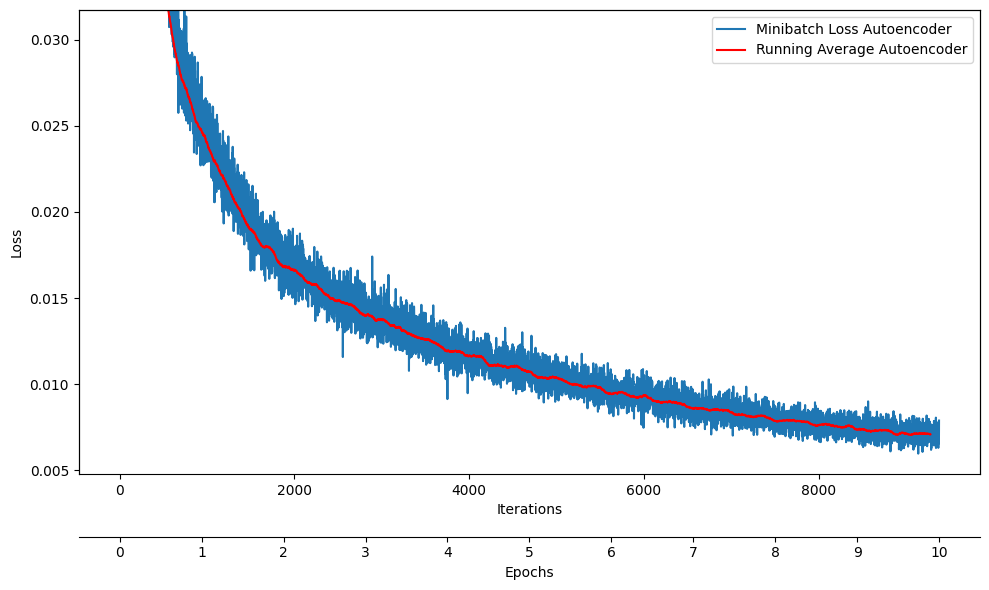

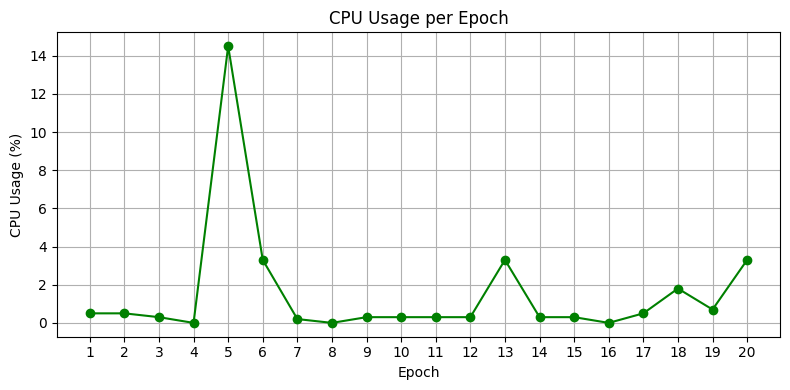

In [17]:
# Plotting training loss and CPU usage per epochs
plot_training_loss(
    minibatch_losses=log_dict['train_loss_per_batch'],
    num_epochs=10,
    cpu_usages=log_dict['cpu_usage_per_epoch'],
    averaging_iterations=100,
    custom_label='Autoencoder'
)

In [18]:
# Getting the mean CPU and Standard Deviation
print(f"Mean CPU usage is {round(np.mean(log_dict['cpu_usage_per_epoch']), 2)}%")
print(f"CPU usage Standard Deviation is {round(np.std(log_dict['cpu_usage_per_epoch']), 2)}%")

Mean CPU usage is 1.54%
CPU usage Standard Deviation is 3.17%


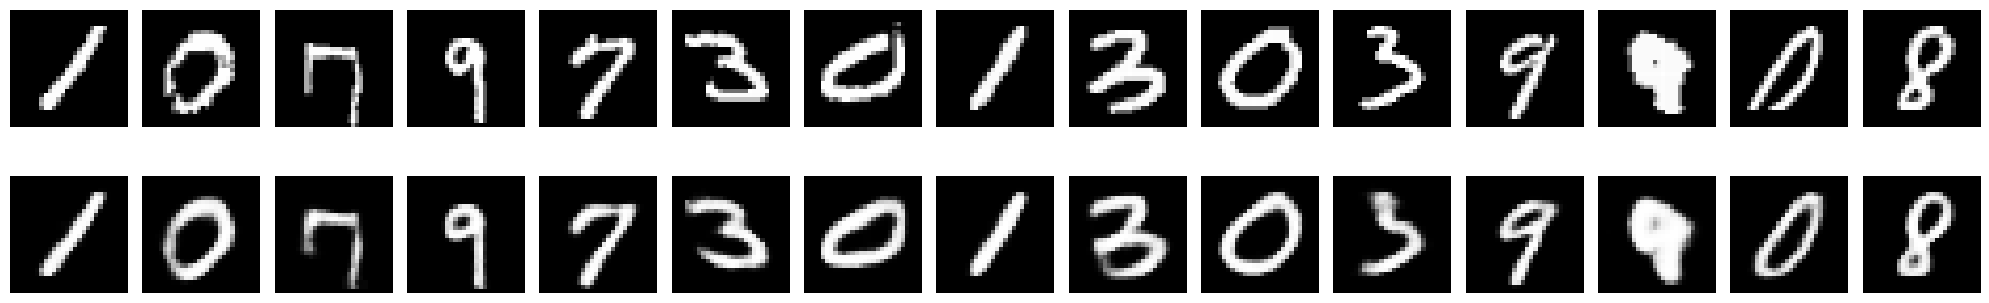

In [19]:
# Plotting generated images
plot_generated_images(data_loader=train_loader, model=model, device=DEVICE)  

Extracting latent vectors: 100%|██████████| 469/469 [00:05<00:00, 88.32it/s]


Running t-SNE...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 60000 samples in 0.002s...
[t-SNE] Computed neighbors for 60000 samples in 14.615s...
[t-SNE] Computed conditional probabilities for sample 1000 / 60000
[t-SNE] Computed conditional probabilities for sample 2000 / 60000
[t-SNE] Computed conditional probabilities for sample 3000 / 60000
[t-SNE] Computed conditional probabilities for sample 4000 / 60000
[t-SNE] Computed conditional probabilities for sample 5000 / 60000
[t-SNE] Computed conditional probabilities for sample 6000 / 60000
[t-SNE] Computed conditional probabilities for sample 7000 / 60000
[t-SNE] Computed conditional probabilities for sample 8000 / 60000
[t-SNE] Computed conditional probabilities for sample 9000 / 60000
[t-SNE] Computed conditional probabilities for sample 10000 / 60000
[t-SNE] Computed conditional probabilities for sample 11000 / 60000
[t-SNE] Computed conditional probabilities for sample 12000 / 60000
[t-SNE] Computed conditional pro

Plotting classes: 100%|██████████| 10/10 [00:00<00:00, 284.20it/s]


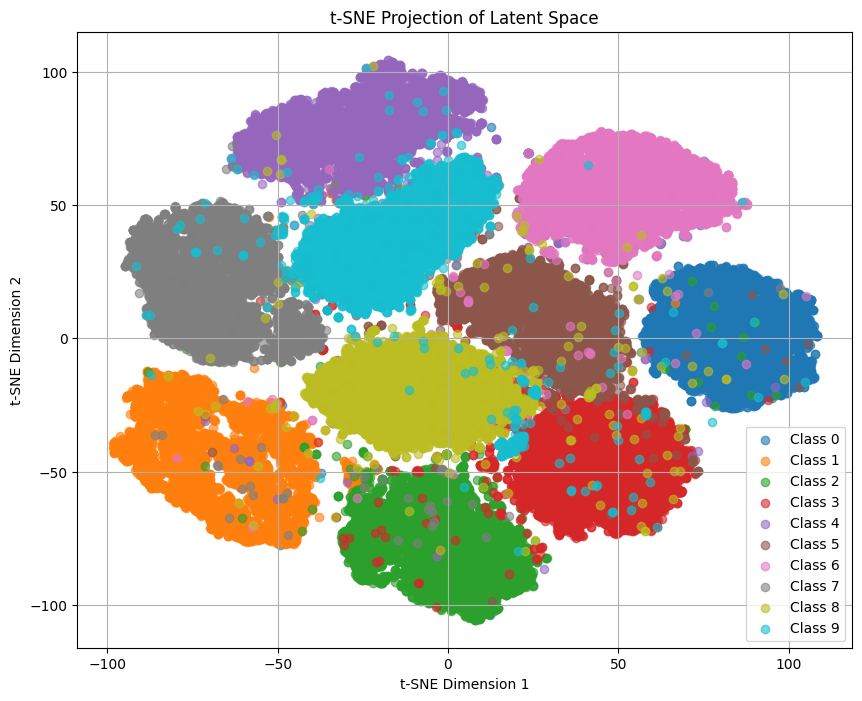

In [20]:
# Visualizing the latent space
plot_latent_space_with_labels(
    num_classes=10,
    data_loader=train_loader,
    model=model, 
    device=DEVICE)


The t-SNE projection of the linear autoencoder’s latent space provides a valuable way to understand how the model is processing and organizing information. What you’re seeing in the visualization is evidence that the autoencoder has learned to recognize meaningful patterns in the handwritten digit images from the MNIST dataset. Specifically, the distinct and well-separated clusters in the plot tell us that the encoder is grouping similar digits—like all the “0”s or “1”s—into nearby regions in the latent space. This means that even without knowing the actual digit labels, the autoencoder has found a way to compress the images into a lower-dimensional space that still preserves their essential characteristics.

The tight, compact nature of each cluster suggests that the autoencoder is not only grouping similar digits together but is doing so consistently. This is a good sign, because it often leads to more accurate reconstructions of the original images. However, you might notice that some clusters overlap slightly. This is expected, especially for digits that look alike—like “4” and “9” or “3” and “8.” These overlaps highlight a common challenge in tasks involving handwritten characters: people write the same digit in different ways, and sometimes different digits can look quite similar.

You’ll also see smaller colored points overlaid on the clusters. If these represent the actual digit labels, their alignment with the clusters adds even more confidence that the autoencoder has captured the structure of the data in a way that reflects the real digit classes—even though it wasn’t trained to do that directly.

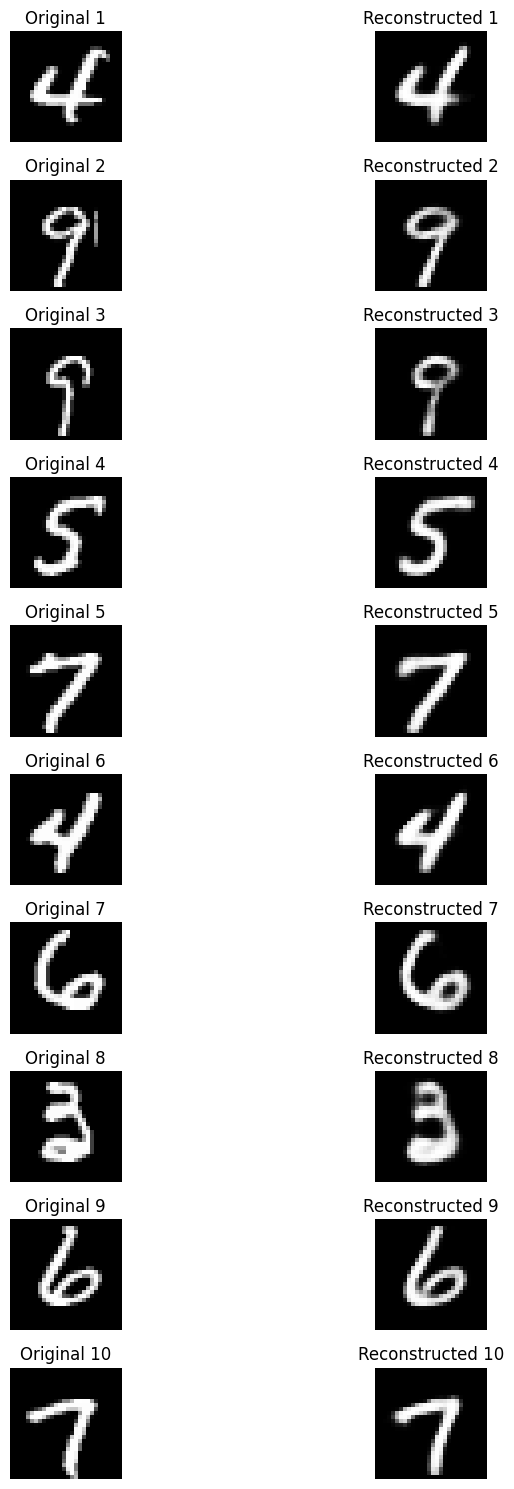

In [21]:
# Plotting reconstructed images
plot_reconstructed_images(model, train_loader, num_images=10)

In [22]:
# Computing the similarity score index between the reconstructed image and the original image for the linear autoencoder
model.eval()
with torch.no_grad():
    for features, _ in test_loader:
        features = features.to(device)
        outputs = model(features)

        # Calculate SSIM
        ssim_score = calculate_ssim(features, outputs)
        print(f"SSIM: {ssim_score:.4f}")

        break  


SSIM: 0.9166


In [23]:
# Computing the FID score for the autoencoder
fid_score = calculate_fid_score(model, test_loader, device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Extracting activations: 100%|██████████| 1000/1000 [01:22<00:00, 12.10it/s]


In [24]:
print(fid_score)

19.38299616098142


In [25]:
# Evaluating the linear autoencoder using the reconstruction loss
evaluate_autoencoder(
    model=model,
    test_loader=test_loader,
    device='cuda'
)

Test Loss: 0.0075


0.007496493799146265

### BUILDING AN AUTOENCODER USING THE NDLINEAR LIBRARY

In [26]:
# Re-creating the autoencoder using the NdLinear library
class AutoEncoder_ND(nn.Module):
    def __init__(self, latent_dim=64):
        super(AutoEncoder_ND, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Flatten(),             # 1x28x28 -> 784
            NdLinear((784,), (128,)),
            nn.LeakyReLU(0.01),
            NdLinear((128,), (64,)),
            nn.LeakyReLU(0.01),
            NdLinear((64,), (12,)),
            nn.LeakyReLU(0.01),
            NdLinear((12,), (latent_dim,))      
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            NdLinear((latent_dim,), (12,)),
            nn.LeakyReLU(0.01),
            NdLinear((12,), (64,)),
            nn.LeakyReLU(0.01),
            NdLinear((64,), (128,)),
            nn.LeakyReLU(0.01),
            NdLinear((128,), (784,)),
            nn.Sigmoid(),             
            nn.Unflatten(1, (1, 28, 28))  
        )
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


In [27]:
model_nd = AutoEncoder_ND()
model_nd.to(DEVICE)

optimizer = torch.optim.Adam(model_nd.parameters(), lr=LEARNING_RATE)  
# Training the NdLinear autoencoder
log_dict_nd = train_autoencoder_v1(num_epochs=NUM_EPOCHS, model=model_nd, 
                                optimizer=optimizer, device=DEVICE, 
                                train_loader=train_loader,
                                skip_epoch_stats=True,
                                logging_interval=250)

Total Trainable Parameters: 221416
Epoch: 001/020 | Batch 0000/469 | Loss: 0.2310
Epoch: 001/020 | Batch 0250/469 | Loss: 0.0654
CPU Usage after Epoch 1: 0.50%
Time elapsed: 0.12 min
Epoch: 002/020 | Batch 0000/469 | Loss: 0.0604
Epoch: 002/020 | Batch 0250/469 | Loss: 0.0528
CPU Usage after Epoch 2: 25.10%
Time elapsed: 0.24 min
Epoch: 003/020 | Batch 0000/469 | Loss: 0.0468
Epoch: 003/020 | Batch 0250/469 | Loss: 0.0438
CPU Usage after Epoch 3: 0.00%
Time elapsed: 0.36 min
Epoch: 004/020 | Batch 0000/469 | Loss: 0.0391
Epoch: 004/020 | Batch 0250/469 | Loss: 0.0347
CPU Usage after Epoch 4: 0.00%
Time elapsed: 0.48 min
Epoch: 005/020 | Batch 0000/469 | Loss: 0.0333
Epoch: 005/020 | Batch 0250/469 | Loss: 0.0318
CPU Usage after Epoch 5: 4.30%
Time elapsed: 0.60 min
Epoch: 006/020 | Batch 0000/469 | Loss: 0.0305
Epoch: 006/020 | Batch 0250/469 | Loss: 0.0308
CPU Usage after Epoch 6: 0.00%
Time elapsed: 0.72 min
Epoch: 007/020 | Batch 0000/469 | Loss: 0.0294
Epoch: 007/020 | Batch 0250/4

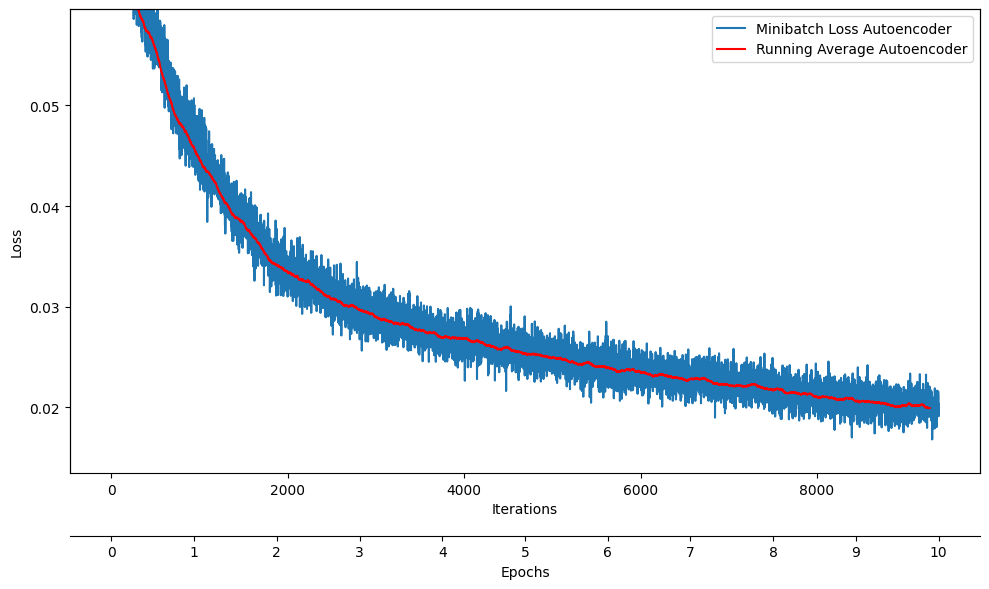

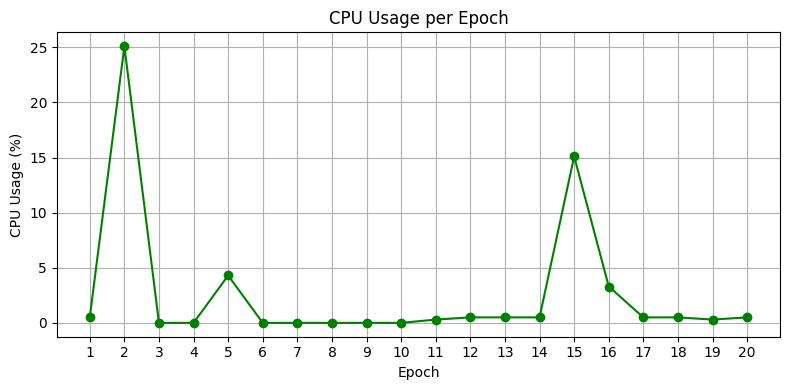

In [28]:
# Visualizing the training loss and CPU usage per epochs
plot_training_loss(
    minibatch_losses=log_dict_nd['train_loss_per_batch'],
    num_epochs=10,
    cpu_usages=log_dict_nd['cpu_usage_per_epoch'],
    averaging_iterations=100,
    custom_label='Autoencoder'
)

In [29]:
# Getting the mean CPU and Standard Deviation
print(f"Mean CPU usage is {round(np.mean(log_dict_nd['cpu_usage_per_epoch']), 2)}%")
print(f"CPU usage Standard Deviation is {round(np.std(log_dict_nd['cpu_usage_per_epoch']), 2)}%")

Mean CPU usage is 2.6%
CPU usage Standard Deviation is 6.14%


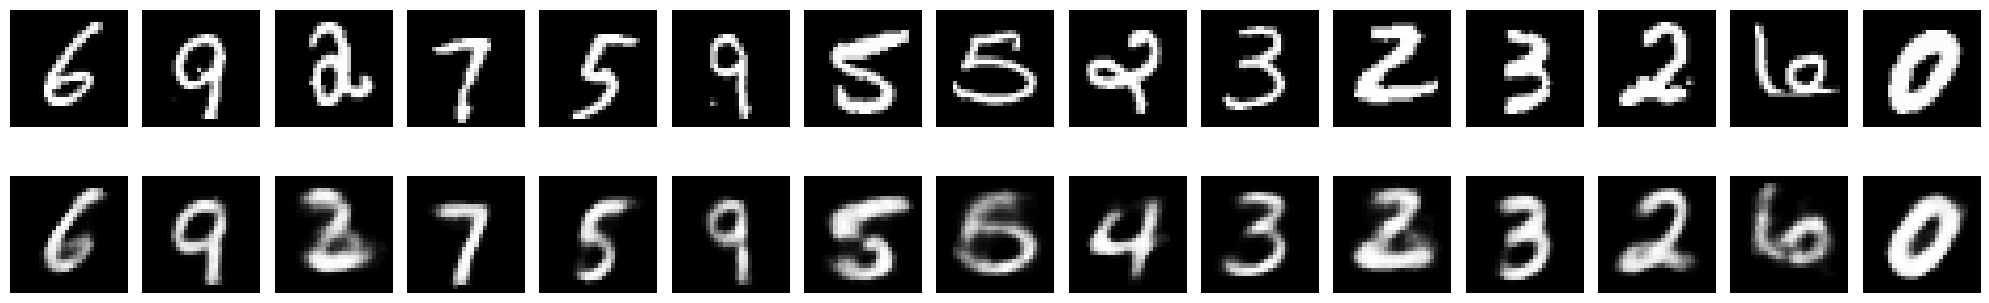

In [30]:
# Plotting generated images
plot_generated_images(data_loader=train_loader, model=model_nd, device=DEVICE)   

Extracting latent vectors: 100%|██████████| 469/469 [00:05<00:00, 91.11it/s]


Running t-SNE...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 60000 samples in 0.002s...
[t-SNE] Computed neighbors for 60000 samples in 13.718s...
[t-SNE] Computed conditional probabilities for sample 1000 / 60000
[t-SNE] Computed conditional probabilities for sample 2000 / 60000
[t-SNE] Computed conditional probabilities for sample 3000 / 60000
[t-SNE] Computed conditional probabilities for sample 4000 / 60000
[t-SNE] Computed conditional probabilities for sample 5000 / 60000
[t-SNE] Computed conditional probabilities for sample 6000 / 60000
[t-SNE] Computed conditional probabilities for sample 7000 / 60000
[t-SNE] Computed conditional probabilities for sample 8000 / 60000
[t-SNE] Computed conditional probabilities for sample 9000 / 60000
[t-SNE] Computed conditional probabilities for sample 10000 / 60000
[t-SNE] Computed conditional probabilities for sample 11000 / 60000
[t-SNE] Computed conditional probabilities for sample 12000 / 60000
[t-SNE] Computed conditional pro

Plotting classes: 100%|██████████| 10/10 [00:00<00:00, 272.56it/s]


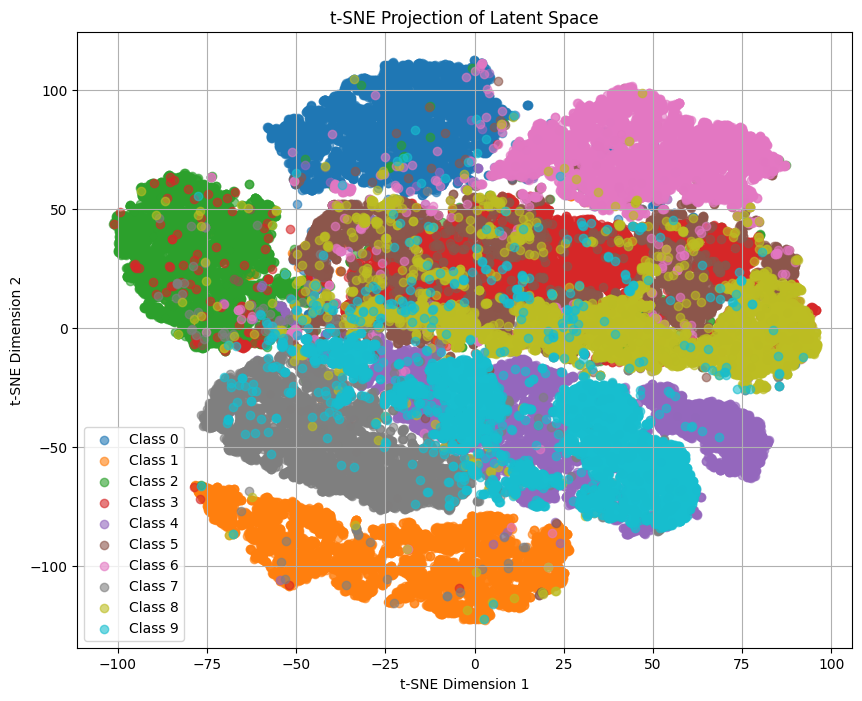

In [31]:
# Visualizing the latent space of the ndlinear autoencoder
plot_latent_space_with_labels(
    num_classes=10,
    data_loader=train_loader,
    model=model_nd, 
    device=DEVICE)

This t-SNE projection illustrates the latent space learned by the NdLinear autoencoder trained on the MNIST dataset. Compared to the linear autoencoder, the NdLinear model produces a more entangled and less separable representation of the digit classes. Although some clusters can still be visually distinguished, there is a noticeable increase in overlap between regions, indicating that the encoder maps different digit classes into shared or adjacent areas of the latent space.

This behavior suggests that the NdLinear autoencoder captures more nuanced and complex patterns within the data, possibly at the cost of clear semantic separation. The increased intermixing of digit classes, such as "9", "6", "3", and "8"—points to the model’s sensitivity to subtle variations in handwriting that linear models might otherwise disregard. As a result, the latent representations are richer in expressive power but less discriminative in terms of class identity.

Nonetheless, the partial formation of clusters implies that the autoencoder retains some ability to organize the latent space in a way that reflects structural similarities in the input data. The lack of well-defined cluster boundaries, however, may challenge its effectiveness in tasks that require clear class separability, such as clustering or classification.

In summary, the NdLinear autoencoder performs not as good as the linear autoencoder.

In [36]:
# Computing the Structural Similarity Index between the reconstructed image and the original image
model_nd.eval()
with torch.no_grad():
    for features, _ in test_loader:
        features = features.to(device)
        outputs = model_nd(features)

        # Calculate SSIM
        ssim_score = calculate_ssim(features, outputs)
        print(f"SSIM: {ssim_score:.4f}")

        break  

SSIM: 0.7603


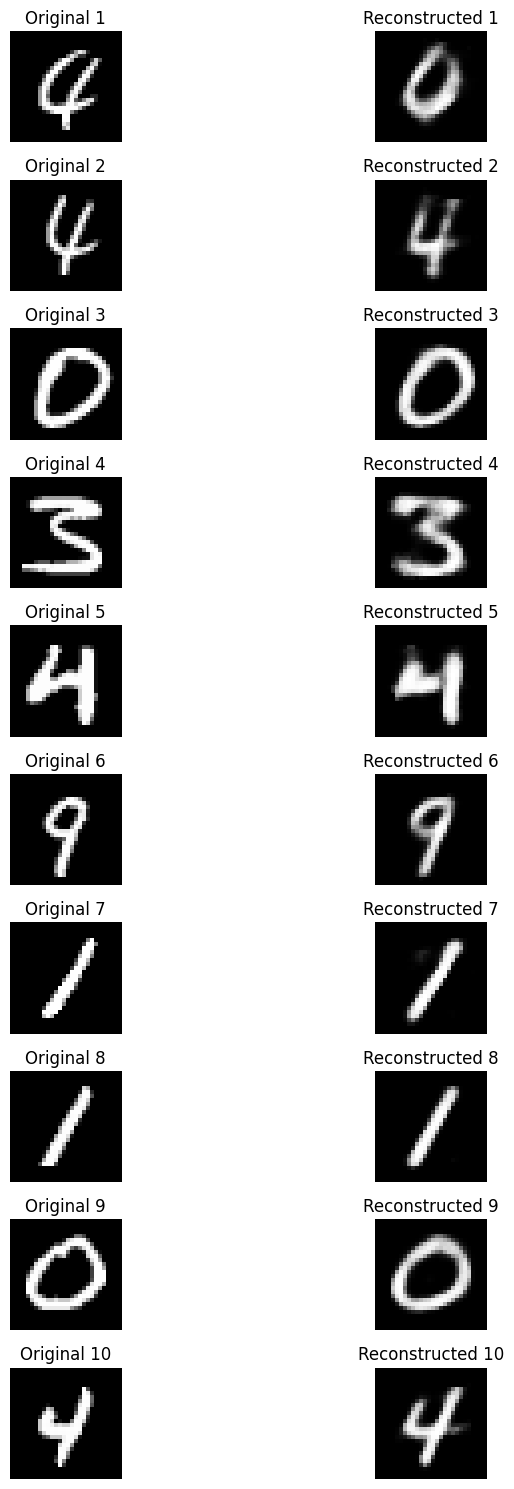

In [33]:
# Plotting the reconstructed images
plot_reconstructed_images(model_nd, train_loader, num_images=10)

In [34]:
# Computing the FID Score of the NdLinear autoencoder
fid_score = calculate_fid_score(model_nd, test_loader, device)
print(f"FID Score: {fid_score:.4f}")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Extracting activations: 100%|██████████| 1000/1000 [01:26<00:00, 11.61it/s]


FID Score: 43.5033


In [35]:
# Evaluating the reconstruction loss of the NdLinear model
evaluate_autoencoder(
    model=model_nd,
    test_loader=test_loader,
    device='cuda'
)

Test Loss: 0.0199


0.01992893367446959